In [31]:
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df = pd.read_csv('data\ASA All PGA Raw Data - Tourn Level.csv')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36864 entries, 0 to 36863
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player_initial_last  36864 non-null  object 
 1   tournament id        36864 non-null  int64  
 2   player id            36864 non-null  int64  
 3   hole_par             36864 non-null  int64  
 4   strokes              36864 non-null  int64  
 5   hole_DKP             36864 non-null  float64
 6   hole_FDP             36864 non-null  float64
 7   hole_SDP             36864 non-null  int64  
 8   streak_DKP           36864 non-null  int64  
 9   streak_FDP           36864 non-null  float64
 10  streak_SDP           36864 non-null  int64  
 11  n_rounds             36864 non-null  int64  
 12  made_cut             36864 non-null  int64  
 13  pos                  21317 non-null  float64
 14  finish_DKP           36864 non-null  int64  
 15  finish_FDP           36864 non-null 

In [34]:
column_index = [1, 5, 6, 7, 8, 9, 10, 20, 21, 22, 23, 24, 26, 28]
df2 = df.drop(df.columns[column_index], axis = 1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36864 entries, 0 to 36863
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player_initial_last  36864 non-null  object 
 1   player id            36864 non-null  int64  
 2   hole_par             36864 non-null  int64  
 3   strokes              36864 non-null  int64  
 4   n_rounds             36864 non-null  int64  
 5   made_cut             36864 non-null  int64  
 6   pos                  21317 non-null  float64
 7   finish_DKP           36864 non-null  int64  
 8   finish_FDP           36864 non-null  int64  
 9   finish_SDP           36864 non-null  int64  
 10  total_DKP            36864 non-null  float64
 11  total_FDP            36864 non-null  float64
 12  total_SDP            36864 non-null  int64  
 13  course               36864 non-null  object 
 14  purse                36864 non-null  float64
 15  no_cut               36864 non-null 

In [35]:
df2.isna().any()

Player_initial_last    False
player id              False
hole_par               False
strokes                False
n_rounds               False
made_cut               False
pos                     True
finish_DKP             False
finish_FDP             False
finish_SDP             False
total_DKP              False
total_FDP              False
total_SDP              False
course                 False
purse                  False
no_cut                 False
Finish                  True
sg_putt                 True
sg_arg                  True
sg_app                  True
sg_ott                  True
sg_t2g                  True
sg_total                True
dtype: bool

In [36]:
df2.replace('Nan', np.nan, inplace = True)
df2.dropna(axis = 0, inplace = True)

In [37]:
df2.isna().any()

Player_initial_last    False
player id              False
hole_par               False
strokes                False
n_rounds               False
made_cut               False
pos                    False
finish_DKP             False
finish_FDP             False
finish_SDP             False
total_DKP              False
total_FDP              False
total_SDP              False
course                 False
purse                  False
no_cut                 False
Finish                 False
sg_putt                False
sg_arg                 False
sg_app                 False
sg_ott                 False
sg_t2g                 False
sg_total               False
dtype: bool

In [38]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 36751
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player_initial_last  16291 non-null  object 
 1   player id            16291 non-null  int64  
 2   hole_par             16291 non-null  int64  
 3   strokes              16291 non-null  int64  
 4   n_rounds             16291 non-null  int64  
 5   made_cut             16291 non-null  int64  
 6   pos                  16291 non-null  float64
 7   finish_DKP           16291 non-null  int64  
 8   finish_FDP           16291 non-null  int64  
 9   finish_SDP           16291 non-null  int64  
 10  total_DKP            16291 non-null  float64
 11  total_FDP            16291 non-null  float64
 12  total_SDP            16291 non-null  int64  
 13  course               16291 non-null  object 
 14  purse                16291 non-null  float64
 15  no_cut               16291 non-null  int6

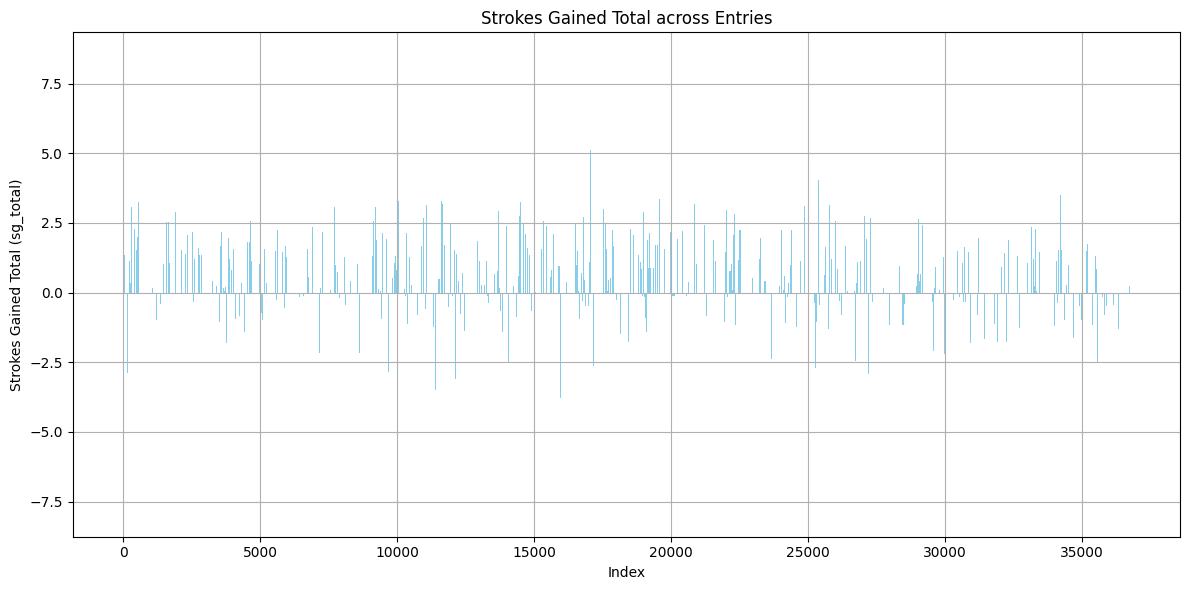

In [39]:
plt.figure(figsize=(12, 6))
plt.bar(df2.index, df2['sg_total'], color='skyblue')
plt.xlabel('Index')
plt.ylabel('Strokes Gained Total (sg_total)')
plt.title('Strokes Gained Total across Entries')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

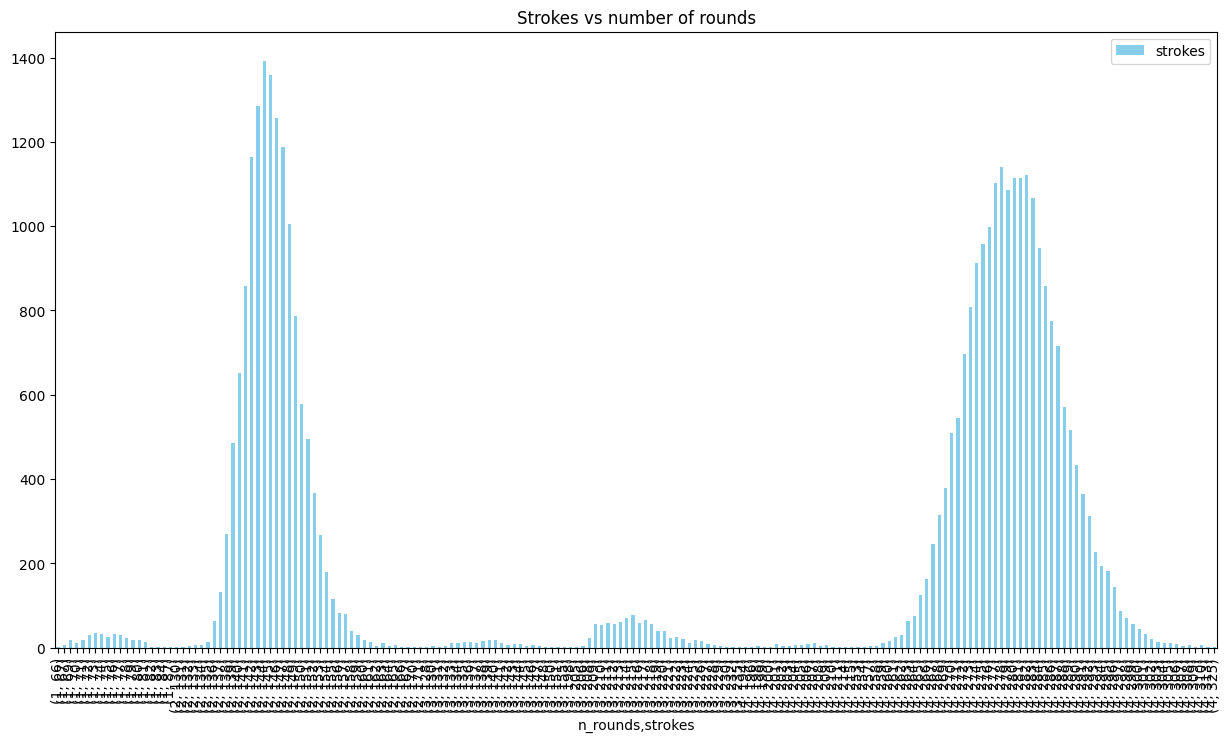

In [40]:
plt.figure(figsize=(15,8))
df.groupby(['n_rounds', 'strokes']).strokes.count().plot(kind = 'bar',color = 'skyblue')
plt.title('Strokes vs number of rounds')
plt.legend()
plt.show()

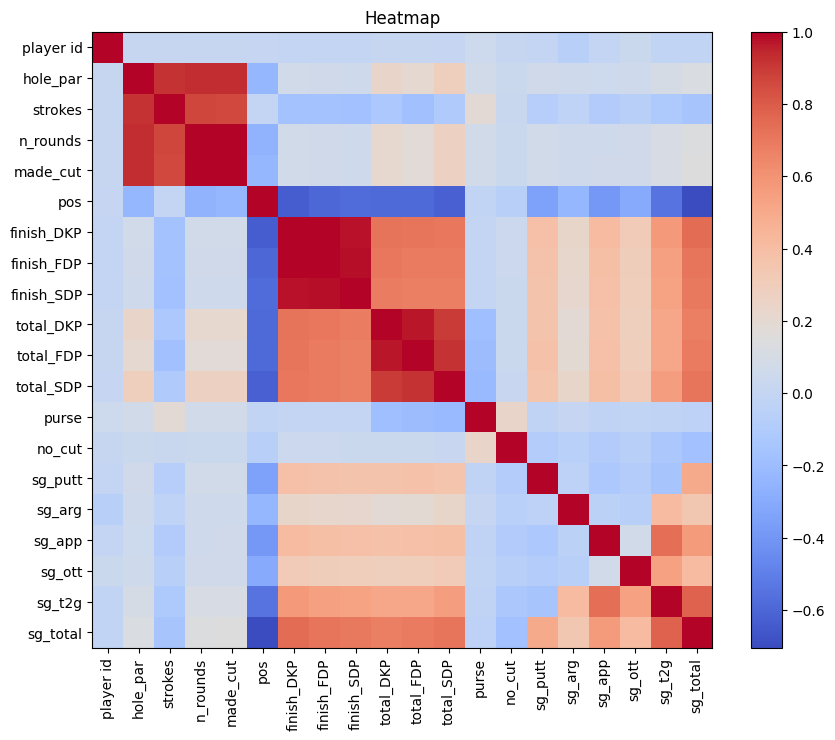

In [41]:
# Drop columns that have string or object
column_index = [0,16,13]
df2 = df2.drop(df2.columns[column_index], axis = 1)

# Calculate the correlation matrix
correlation_matrix = df2.corr()

# Plotting the heatmap
plt.figure(figsize = (10,8))
plt.imshow(correlation_matrix, cmap = 'coolwarm', interpolation='none', aspect='auto')
plt.colorbar()

# Add labels
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Heatmap')
plt.show()

## Organize and convert aggregated df to csv

In [42]:
# Read the csv file
df = pd.read_csv('data/aggregated_df.csv')

# Soer df by column name
df.sort_index(axis = 1, inplace=True)

# Convert sorted df into a new csv file
df.to_csv('data/aggregated_df_ordered.csv', index = False)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 79 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   # HOLES(7)                177 non-null    float64
 1   # OF SHOTS                177 non-null    float64
 2   %(11)                     177 non-null    object 
 3   %(4)                      177 non-null    object 
 4   %(7)                      177 non-null    object 
 5   AVG DTP(5)                177 non-null    object 
 6   AVG(1)                    177 non-null    float64
 7   AVG(10)                   177 non-null    float64
 8   AVG(12)                   177 non-null    float64
 9   AVG(13)                   177 non-null    float64
 10  AVG(14)                   177 non-null    float64
 11  AVG(2)                    177 non-null    float64
 12  AVG(3)                    177 non-null    float64
 13  AVG(6)                    177 non-null    float64
 14  AVG(8)    

## After Looking at the heatmap and sorting the df, we want to now remoev unecessary columns

In [44]:
# Read the csv file
df = pd.read_csv('data/aggregated_df_ordered_copy.csv')

# Make a list of column names that we want to remove
columns_to_drop = ['MOVEMENT(1)','MOVEMENT(10)','MOVEMENT(11)',
                   'MOVEMENT(12)','MOVEMENT(13)','MOVEMENT(14)',
                   'MOVEMENT(2)','MOVEMENT(3)','MOVEMENT(4)',
                   'MOVEMENT(5)','MOVEMENT(6)','MOVEMENT(7)',
                   'MOVEMENT(8)','MOVEMENT(9)','RANK(0)','RANK(1)',
                   'RANK(11)','RANK(12)','RANK(13)','RANK(2)','RANK(3)',
                   'RANK(4)','RANK(5)','RANK(6)','RANK(7)','RANK(8)', 'RANK(9)',
                   'RANK(10)', 'REMOVE','PLAYER','MEASURED ROUNDS(1)','MEASURED ROUNDS(12)',
                   'MEASURED ROUNDS(2)','MEASURED ROUNDS(3)','MEASURED ROUNDS(6)',
                   'MEASURED ROUNDS(8)','MEASURED ROUNDS(9)']

# Drop columns
df.drop(columns = columns_to_drop, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   # HOLES(7)                177 non-null    float64
 1   # OF SHOTS(5)             177 non-null    float64
 2   %(11)                     177 non-null    object 
 3   %(4)                      177 non-null    object 
 4   %(7)                      177 non-null    object 
 5   AVG DTP(5)                177 non-null    object 
 6   AVG_STROKE                177 non-null    float64
 7   AVG_SG_PUTTING            177 non-null    float64
 8   AVG_DRIVING_DISTANCE      177 non-null    float64
 9   AVG_SG                    177 non-null    float64
 10  AVG_UNADJUSTED_STROKE     177 non-null    float64
 11  AVG_ARG                   177 non-null    float64
 12  AVG_APP                   177 non-null    float64
 13  AVG_COMBINED              177 non-null    float64
 14  AVG_OTT   

### We notice that some of the columns are of Object datatype
We can edit them so that they are all numerical. At this point, we can just make the entire datframe into the same datatype

In [49]:
# Function to clean all strings and columns
def remove_percent_sign(df):
    for x in df.columns:
        if df[x].dtype == 'object':
            if df[x].str.contains('%').any():
                df[x] = df[x].str.replace('%','',regex = False)
    return df

In [53]:
# Remove Object data types
df['%(11)'] = df['%(11)'].str.replace('%', '', regex = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   # HOLES(7)                177 non-null    float64
 1   # OF SHOTS(5)             177 non-null    float64
 2   %(11)                     177 non-null    object 
 3   %(4)                      177 non-null    object 
 4   %(7)                      177 non-null    object 
 5   AVG DTP(5)                177 non-null    object 
 6   AVG_STROKE                177 non-null    float64
 7   AVG_SG_PUTTING            177 non-null    float64
 8   AVG_DRIVING_DISTANCE      177 non-null    float64
 9   AVG_SG                    177 non-null    float64
 10  AVG_UNADJUSTED_STROKE     177 non-null    float64
 11  AVG_ARG                   177 non-null    float64
 12  AVG_APP                   177 non-null    float64
 13  AVG_COMBINED              177 non-null    float64
 14  AVG_OTT   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


X = 
y = df[['TOTAL STROKES(13)']]

# Create variables for models
linear_model = LinearRegression()
rf_model = RandomForestRegressor()
svr_model = SVR()

# Train the model
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)

linear_model.predict()